### import

In [124]:
import torch
from torch import nn
from torch.functional import F
from torch.distributions import Multinomial, Categorical
from torch import optim
from torch.optim import Adam
import numpy as np
import importlib as imp
import actor
import envs
import utils
imp.reload(actor)
imp.reload(envs)
imp.reload(utils)
from actor import Actor, Critic, LinearCritic
from envs import HospitalEnv
from utils import mlp_sample, ppo_update
from env_config import ENV_CONFIG as config
from tqdm import tqdm

In [30]:
%load_ext autoreload
%autoreload 1

In [141]:
env = HospitalEnv(config)
act = Actor(config)
crtc = LinearCritic(config)
optimizer_actor = Adam(act.parameters(), lr=1e-4)
optimizer_critic = Adam(crtc.parameters(), lr=1e-3)

In [142]:
config["Simulation_days"] = 100
config["Clipping_parameter"] = 0.2
config["max_norm"] = 0.5
epochs = 1

In [148]:
for i in range(epochs):
    trajectory = mlp_sample(env, act, config, is_random=True)
    states = torch.stack([t['state'] for t in trajectory]).float()
    actions = torch.stack([t['action'] for t in trajectory]).float()
    costs = torch.tensor([t['cost'] for t in trajectory], dtype=torch.float32)
    next_states = torch.stack([t['next_state'] for t in trajectory]).float()

    # Recompute log_probs using current logits for compatibility with PPO update
    logits = torch.stack([t['logits'] for t in trajectory]).float()
    old_probs = F.log_softmax(logits, dim=-1)

    memory = (states, actions, old_probs, costs, next_states)
    ppo_update(act, crtc, memory, optimizer_actor, optimizer_critic, config)
    print(costs.mean() * 8)

Sample: 100%|██████████| 800/800 [00:06<00:00, 132.57it/s]
                                                              

tensor(274.8800)


In [149]:
crtc_loss = [l.detach().item() for l in crtc.loss]
act_loss = [l.detach().item() for l in act.loss]


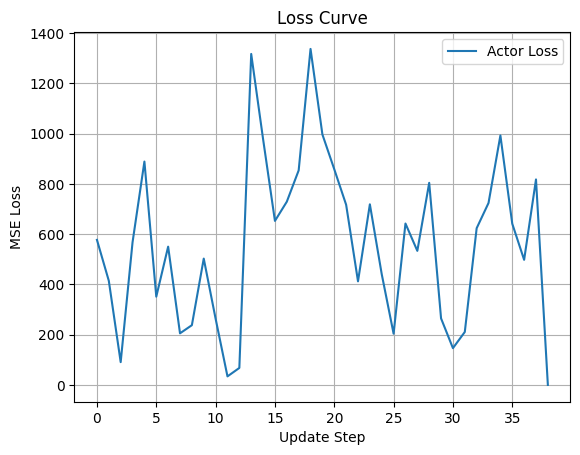

In [150]:
import matplotlib.pyplot as plt
import numpy as np
# plt.plot(crtc.loss, label="Critic Loss")
plt.plot(act_loss, label="Actor Loss")
plt.xlabel("Update Step")
plt.ylabel("MSE Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [77]:
costs = torch.tensor([t['cost'] for t in trajectory], dtype=torch.float32)
costs.mean(), costs.mean() * 8

(tensor(34.6159), tensor(276.9270))

In [62]:
j = 3
for h in range(1, 8):
    eps = 1e-10
    F_h = env.discharge_cdf[j][3*h]
    F_h_prime = env.discharge_cdf[j][3*(h-1)]
    probs = (F_h - F_h_prime + eps) / (1 - F_h_prime + eps)
    x = torch.distributions.Binomial(
                        total_count=env.Y_j[j], probs=probs
                    ).sample().int()
    print(probs, x)


tensor(1.0000e-10) tensor(0, dtype=torch.int32)
tensor(0.0800) tensor(2, dtype=torch.int32)
tensor(0.2609) tensor(5, dtype=torch.int32)
tensor(0.3529) tensor(7, dtype=torch.int32)
tensor(0.5455) tensor(16, dtype=torch.int32)
tensor(1.) tensor(24, dtype=torch.int32)
tensor(1.) tensor(24, dtype=torch.int32)
